In [68]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import gensim
import spacy
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import Counter
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB

In [26]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jnske\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jnske\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [4]:
general_df = pd.read_csv('./data/NSS_DS_data.thegeneral.csv')

In [123]:
general_df.head()

,ClaimID_RGEN,ExposureID_RGEN,ClaimLevelBody,ExposureLevelBody,AccidentDescription,InjuryDescription,DamageDescription,SeverityTypeName,ClaimGroup,FaultRatingName,LossCauseName,CCCreateTime,CloseDate,StateName,AccidentDescription_tok,DamageDescription_tok,LossCauseName_tok
0,10000,131005,reviewed\r\ncoverage sc rated policy and loss...,none none liability accepted by adverse and da...,"[insured, test, driving, vehicle, ov, pulled, ...",neckback,front left side damages towed collision tow i...,Moderate,Tampa Field Ops,Other party at fault,Collision with motor vehicle,2015-03-12 09:05:17.9100000,2015-04-29 11:25:18.3190000,South Carolina,insured test driving vehicle ov pulled parking...,front left side damages towed collision tow gr...,Collision motor vehicle
1,10001,131006,c dol *******\r\n tol *** pm\r\n v...,c coverage\r\ndol *****\r\nfnol ***** by ni \...,"[iv, driving, road, ov, turning, lane, suddenl...",pain,front right headlight front side of bumper dr...,Minor,Tampa Field Ops,Other party at fault,Collision while merging / lane change,2015-03-12 11:46:23.1590000,2015-07-06 08:26:47.5350000,Florida,iv driving road ov turning lane suddenly swerv...,front right headlight front side bumper drivab...,Collision merging / lane change
2,10002,131007,insured was in the hospital and lost service ...,none none c coverage\r\ndol *****\r\nfnol ***...,"[insured, stopped, stop, light, cv, rear, ende...",strain,unknown damages rear bumper trunk right rear ...,Minor,Tampa Field Ops,Other party at fault,Rear-end collision,2015-03-12 13:12:35.4440000,2017-11-20 14:17:39.0910000,Florida,insured stopped stop light cv rear ended iv,unknown damages rear bumper trunk right rear l...,Rear-end collision
3,10003,131008,insured was in the hospital and lost service ...,none none hhcsi dos ****** atd for brant willi...,"[insured, stopped, stop, light, cv, rear, ende...",back,unknown damages rear bumper trunk right rear ...,NaN,Tampa Field Ops,Other party at fault,Rear-end collision,2015-03-12 13:12:35.4440000,2017-11-20 14:17:39.0910000,Florida,insured stopped stop light cv rear ended iv,unknown damages rear bumper trunk right rear l...,Rear-end collision
4,10004,131009,adjuster out of office\r\nreassigned adjuster ...,new pip loss received additional action neede...,"[ov, host, veh]",neck back,none none none,Minor,Fast Track,Other party at fault,Collision with motor vehicle,2015-03-12 16:35:17.3570000,2016-01-29 13:54:25.6150000,Florida,ov host veh,none none none,Collision motor vehicle


In [6]:
general_df.shape

(120657, 14)

In [7]:
general_df.FaultRatingName.unique()

array(['Other party at fault', 'Insured at fault', 'No fault',
       'Comparative Negligence', 'Fault unknown', nan], dtype=object)

In [8]:
general_df.FaultRatingName.value_counts()

Insured at fault          74304
Other party at fault      29394
Comparative Negligence     8178
No fault                   7395
Fault unknown              1385
Name: FaultRatingName, dtype: int64

#### These are our possible outcomes for the faults at claim level (Other Party at Fault, Insured at Fault, No Fault, Comparative Negligence, Fault Unknown). Insured at Fault consists of ~62% of all incidents.

Text(0.5,0,'Percentage of occurences')

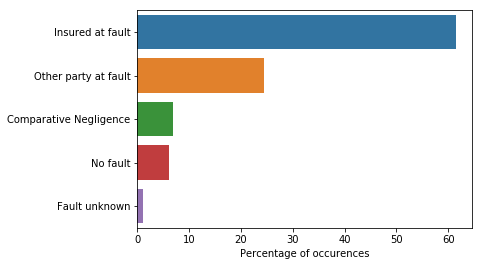

In [20]:
fault_type = (general_df.FaultRatingName.value_counts(ascending=False, sort=True, normalize=True)*100).reset_index()
#sns.set(rc={'figure.figsize':(15,10)}, font_scale=2)
sns.barplot(x="FaultRatingName", y="index", data=fault_type)
plt.ylabel('', fontsize=20)
plt.xlabel('Percentage of occurences')

In [15]:
general_df.SeverityTypeName.value_counts()

Minor                                     57468
Moderate                                  24631
Major (hospitalization 3+ days or ICU)     4422
Death                                       955
Life-threatening                            223
Name: SeverityTypeName, dtype: int64

Text(0.5,0,'Percentage of occurences')

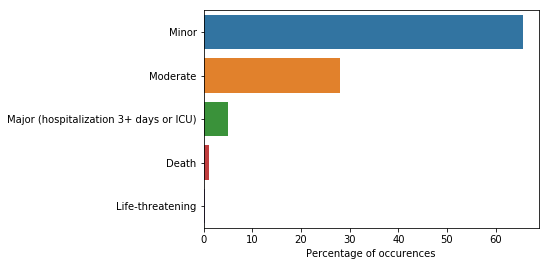

In [18]:
severity = (general_df.SeverityTypeName.value_counts(ascending=False, sort=True, normalize=True)*100).reset_index()
sns.barplot(x="SeverityTypeName", y="index", data=severity)
plt.ylabel('', fontsize=20)
plt.xlabel('Percentage of occurences')

In [28]:
tokenizer = RegexpTokenizer(r'\w+') #chosen over word_tokenize for the sake of speed and simiplicity

token_df = general_df.iloc[:, 2:11]
token_df.head()

,ClaimLevelBody,ExposureLevelBody,AccidentDescription,InjuryDescription,DamageDescription,SeverityTypeName,ClaimGroup,FaultRatingName,LossCauseName
0,reviewed\r\ncoverage sc rated policy and loss...,none none liability accepted by adverse and da...,the insured was test driving a vehicle the ov...,neckback,front left side damages towed collision tow i...,Moderate,Tampa Field Ops,Other party at fault,Collision with motor vehicle
1,c dol *******\r\n tol *** pm\r\n v...,c coverage\r\ndol *****\r\nfnol ***** by ni \...,the iv was driving down the road when the ov i...,pain,front right headlight front side of bumper dr...,Minor,Tampa Field Ops,Other party at fault,Collision while merging / lane change
2,insured was in the hospital and lost service ...,none none c coverage\r\ndol *****\r\nfnol ***...,insured was stopped at the stop light when cv ...,strain,unknown damages rear bumper trunk right rear ...,Minor,Tampa Field Ops,Other party at fault,Rear-end collision
3,insured was in the hospital and lost service ...,none none hhcsi dos ****** atd for brant willi...,insured was stopped at the stop light when cv ...,back,unknown damages rear bumper trunk right rear ...,NaN,Tampa Field Ops,Other party at fault,Rear-end collision
4,adjuster out of office\r\nreassigned adjuster ...,new pip loss received additional action neede...,ov re host veh,neck back,none none none,Minor,Fast Track,Other party at fault,Collision with motor vehicle


In [43]:
stop_words = stopwords.words('english')
token_df['AccidentDescription_tok'] = token_df['AccidentDescription'].apply(lambda x: ' '.join(w for w in str(x).split()
                                                                                               if w not in stop_words))
token_df['DamageDescription_tok'] = token_df['DamageDescription'].apply(lambda x: ' '.join(w for w in str(x).split()
                                                                                           if w not in stop_words))
token_df['LossCauseName_tok'] = token_df['LossCauseName'].apply(lambda x: ' '.join(w for w in str(x).split() 
                                                                                   if w not in stop_words))

In [44]:
token_df['AccidentDescription_tok'] = token_df['AccidentDescription_tok'].apply(tokenizer.tokenize)
# token_df['InjuryDescription_tok'] = token_df['InjuryDescription'].apply(tokenizer.tokenize)
token_df['DamageDescription_tok'] = token_df['DamageDescription_tok'].apply(tokenizer.tokenize)
# token_df['FaultRatingName_tok'] = token_df['FaultRatingName'].apply(tokenizer.tokenize)
token_df['LossCauseName_tok'] = token_df['LossCauseName_tok'].apply(tokenizer.tokenize)
    
token_df.head()

,ClaimLevelBody,ExposureLevelBody,AccidentDescription,InjuryDescription,DamageDescription,SeverityTypeName,ClaimGroup,FaultRatingName,LossCauseName,AccidentDescription_tok,DamageDescription_tok,LossCauseName_tok
0,reviewed\r\ncoverage sc rated policy and loss...,none none liability accepted by adverse and da...,the insured was test driving a vehicle the ov...,neckback,front left side damages towed collision tow i...,Moderate,Tampa Field Ops,Other party at fault,Collision with motor vehicle,"[insured, test, driving, vehicle, ov, pulled, ...","[front, left, side, damages, towed, collision,...","[Collision, motor, vehicle]"
1,c dol *******\r\n tol *** pm\r\n v...,c coverage\r\ndol *****\r\nfnol ***** by ni \...,the iv was driving down the road when the ov i...,pain,front right headlight front side of bumper dr...,Minor,Tampa Field Ops,Other party at fault,Collision while merging / lane change,"[iv, driving, road, ov, turning, lane, suddenl...","[front, right, headlight, front, side, bumper,...","[Collision, merging, lane, change]"
2,insured was in the hospital and lost service ...,none none c coverage\r\ndol *****\r\nfnol ***...,insured was stopped at the stop light when cv ...,strain,unknown damages rear bumper trunk right rear ...,Minor,Tampa Field Ops,Other party at fault,Rear-end collision,"[insured, stopped, stop, light, cv, rear, ende...","[unknown, damages, rear, bumper, trunk, right,...","[Rear, end, collision]"
3,insured was in the hospital and lost service ...,none none hhcsi dos ****** atd for brant willi...,insured was stopped at the stop light when cv ...,back,unknown damages rear bumper trunk right rear ...,NaN,Tampa Field Ops,Other party at fault,Rear-end collision,"[insured, stopped, stop, light, cv, rear, ende...","[unknown, damages, rear, bumper, trunk, right,...","[Rear, end, collision]"
4,adjuster out of office\r\nreassigned adjuster ...,new pip loss received additional action neede...,ov re host veh,neck back,none none none,Minor,Fast Track,Other party at fault,Collision with motor vehicle,"[ov, host, veh]","[none, none, none]","[Collision, motor, vehicle]"


In [45]:
Counter(np.concatenate(token_df.LossCauseName_tok)).most_common(10)

[('Collision', 69056),
 ('end', 45122),
 ('IV', 41648),
 ('rear', 40596),
 ('CV', 40596),
 ('intersection', 19367),
 ('motor', 17548),
 ('vehicle', 17548),
 ('merging', 10694),
 ('lane', 10694)]

In [46]:
all_words = [word for tokens in token_df["AccidentDescription_tok"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in token_df["AccidentDescription_tok"]]

VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

1251569 words total, with a vocabulary size of 8456
Max sentence length is 105


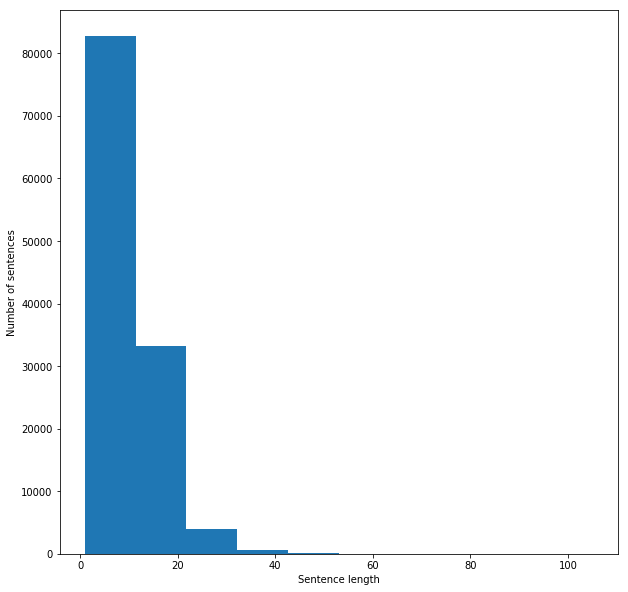

In [47]:
fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths)
plt.show()

In [81]:
def cv(data):
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

list_corpus_acc = token_df["AccidentDescription"].tolist()
list_labels_acc = token_df["FaultRatingName"].tolist()

X_train_acc, X_test_acc, y_train_acc, y_test_acc = train_test_split(list_corpus_acc, list_labels_acc, 
                                                                    test_size=0.2, random_state=42)

X_train_counts_acc, count_vectorizer_acc = cv(X_train_acc)
X_test_counts_acc = count_vectorizer_acc.transform(X_test_acc)

In [82]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=42)
clf.fit(X_train_counts_acc, y_train_acc)

y_predicted_counts_acc = clf.predict(X_test_counts_acc)

In [83]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test_acc, y_predicted_counts_acc)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

C:\Users\jnske\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jnske\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


accuracy = 0.512, precision = 0.673, recall = 0.512, f1 = 0.564


In [84]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=10, rotation = 90)
    plt.yticks(tick_marks, classes, fontsize=10)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=20)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

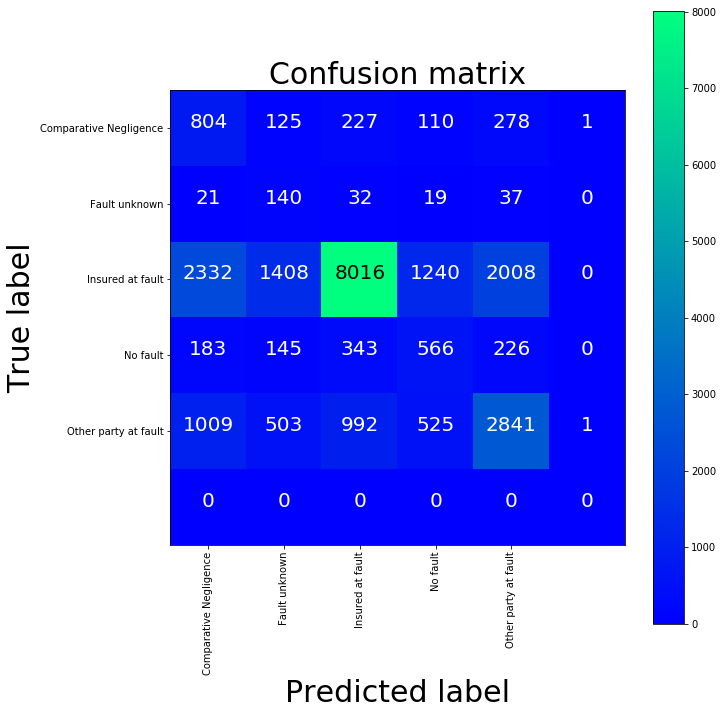

In [85]:
cm = confusion_matrix(y_test_acc, y_predicted_counts_acc)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Comparative Negligence', 'Fault unknown', 'Insured at fault', 'No fault', 
                                          'Other party at fault'], normalize=False, title='Confusion matrix')
plt.show()
# print(cm)

In [94]:
tfidf_vectorizer_acc = TfidfVectorizer(ngram_range=(1,3))
tfidf_train_acc = tfidf_vectorizer_acc.fit_transform(X_train_acc)

tfidf_test_acc = tfidf_vectorizer_acc.transform(X_test_acc)

feature_names_acc = tfidf_vectorizer_acc.get_feature_names()
feature_names_acc

['aa',
 'aa highway',
 'aa highway and',
 'aa left',
 'aa left hand',
 'aaa',
 'aaa proceeding',
 'aaa proceeding straight',
 'abandon',
 'abandon cv',
 'abandoned',
 'abandoned cv',
 'abandoned cv cv',
 'abandoned down',
 'abandoned down the',
 'abandoned house',
 'abandoned in',
 'abandoned in the',
 'abandoned on',
 'abandoned on the',
 'abandoned truck',
 'abandoned truck in',
 'abandoned vehicle',
 'abandoned vehicle and',
 'abandoned vehicle in',
 'abbey',
 'abbey church',
 'abd',
 'abd cv',
 'abd cv collided',
 'abdel',
 'abdel roach',
 'abdel roach attorney',
 'abject',
 'able',
 'able license',
 'able license plate',
 'able to',
 'able to and',
 'able to avoid',
 'able to back',
 'able to brake',
 'able to capture',
 'able to causing',
 'able to complete',
 'able to control',
 'able to drive',
 'able to escape',
 'able to find',
 'able to fine',
 'able to follow',
 'able to gain',
 'able to get',
 'able to go',
 'able to in',
 'able to locate',
 'able to make',
 'able to move'

In [96]:
# Naive Bayes 
nb_classifier_acc = MultinomialNB(alpha=0.02)
nb_classifier_acc.fit(tfidf_train_acc, y_train_acc)
pred_acc = nb_classifier_acc.predict(tfidf_test_acc)

In [97]:
from sklearn import metrics

print(metrics.confusion_matrix(y_test_acc,pred_acc))
print('\n', 'Classification report')
print(metrics.classification_report(y_test_acc,pred_acc))
# Print the overall accuracy
print('\n', 'accuracy Score')
print(metrics.accuracy_score(y_test_acc,pred_acc))

[[  706     0   563    25   251]
 [    6    90    79     8    66]
 [  291    21 13858   167   667]
 [   37     2   644   562   218]
 [   99     4   923   113  4732]]

 Classification report
                        precision    recall  f1-score   support

Comparative Negligence       0.62      0.46      0.53      1545
         Fault unknown       0.77      0.36      0.49       249
      Insured at fault       0.86      0.92      0.89     15004
              No fault       0.64      0.38      0.48      1463
  Other party at fault       0.80      0.81      0.80      5871

             micro avg       0.83      0.83      0.83     24132
             macro avg       0.74      0.59      0.64     24132
          weighted avg       0.82      0.83      0.82     24132


 accuracy Score
0.8266202552627216


#### Comparative Negligence scores would likely improve by adding state information to corpus

In [88]:
all_words_2 = [word for tokens in token_df["DamageDescription_tok"] for word in tokens]
sentence_lengths_2 = [len(tokens) for tokens in token_df["DamageDescription_tok"]]

VOCAB_2 = sorted(list(set(all_words_2)))
print("%s words total, with a vocabulary size of %s" % (len(all_words_2), len(VOCAB_2)))
print("Max sentence length is %s" % max(sentence_lengths_2))

1786254 words total, with a vocabulary size of 13851
Max sentence length is 154


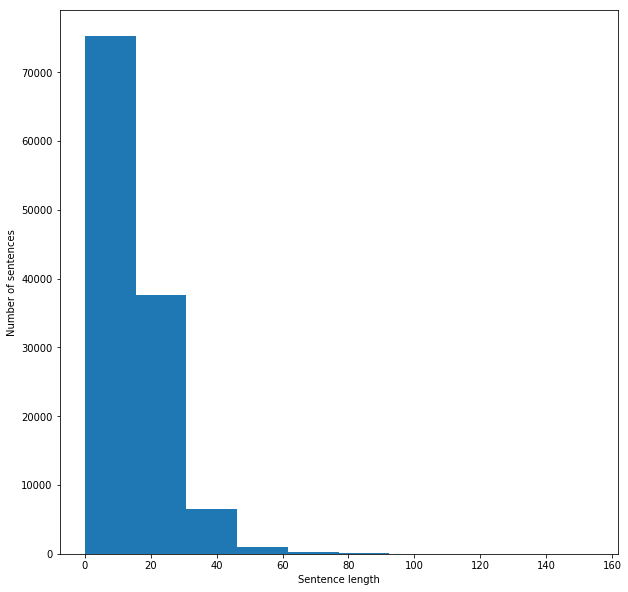

In [89]:
fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths_2)
plt.show()

In [90]:
list_corpus_dmg = token_df["DamageDescription"].tolist()
list_labels_dmg = token_df["FaultRatingName"].tolist()

X_train_dmg, X_test_dmg, y_train_dmg, y_test_dmg = train_test_split(list_corpus_dmg, list_labels_dmg, 
                                                                    test_size=0.2, random_state=42)

X_train_counts_dmg, count_vectorizer_dmg = cv(X_train_dmg)
X_test_counts_dmg = count_vectorizer_dmg.transform(X_test_dmg)

In [91]:
clf_2 = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=42)
clf_2.fit(X_train_counts_dmg, y_train_dmg)

y_predicted_counts_dmg = clf_2.predict(X_test_counts_dmg)

In [92]:
accuracy, precision, recall, f1 = get_metrics(y_test_dmg, y_predicted_counts_dmg)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.416, precision = 0.618, recall = 0.416, f1 = 0.472


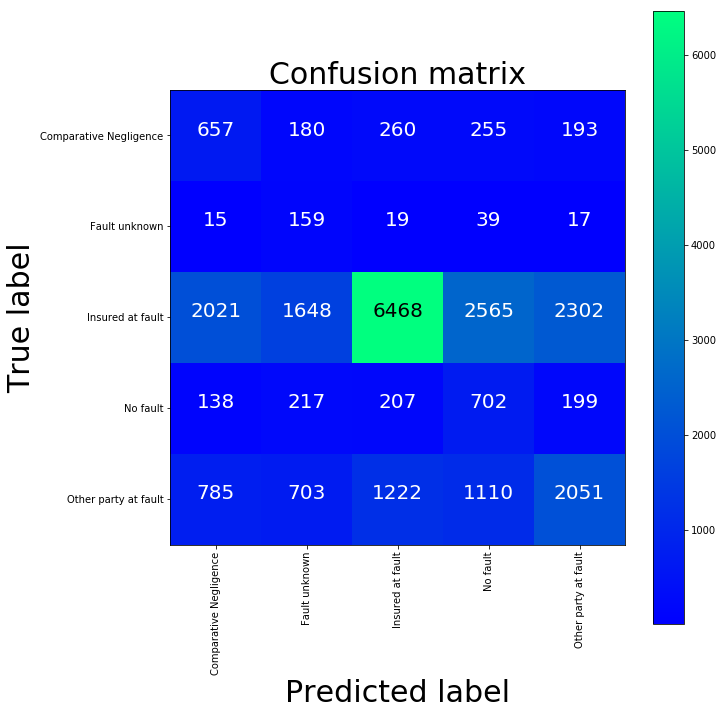

In [93]:
cm = confusion_matrix(y_test_dmg, y_predicted_counts_dmg)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Comparative Negligence', 'Fault unknown', 'Insured at fault', 'No fault', 
                                          'Other party at fault'], normalize=False, title='Confusion matrix')
plt.show()

In [98]:
tfidf_vectorizer_dmg = TfidfVectorizer(ngram_range=(1,3))
tfidf_train_dmg = tfidf_vectorizer_dmg.fit_transform(X_train_dmg)

tfidf_test_dmg = tfidf_vectorizer_dmg.transform(X_test_dmg)

feature_names_dmg = tfidf_vectorizer_dmg.get_feature_names()
feature_names_dmg

['_magills',
 '_magills towing',
 '_magills towing phone',
 'aa',
 'aa auto',
 'aa auto repair',
 'aa paint',
 'aa paint body',
 'aa towing',
 'aa towing damages',
 'aa towing marlboro',
 'aa towing ph',
 'aa towing phone',
 'aa towing to',
 'aa wrecker',
 'aa wrecker service',
 'aaa',
 'aaa address',
 'aaa address santa',
 'aaa at',
 'aaa at lees',
 'aaa auto',
 'aaa auto service',
 'aaa back',
 'aaa back fender',
 'aaa back home',
 'aaa back left',
 'aaa back to',
 'aaa beau',
 'aaa beau townsmen',
 'aaa bryants',
 'aaa bryants towing',
 'aaa bumper',
 'aaa bumper is',
 'aaa call',
 'aaa call was',
 'aaa classic',
 'aaa classic ford',
 'aaa damages',
 'aaa damages unknown',
 'aaa dan',
 'aaa dan phone',
 'aaa entire',
 'aaa entire right',
 'aaa frencing',
 'aaa front',
 'aaa front and',
 'aaa front bumper',
 'aaa front center',
 'aaa front end',
 'aaa front left',
 'aaa gm',
 'aaa gm towing',
 'aaa he',
 'aaa he states',
 'aaa heavy',
 'aaa heavy front',
 'aaa heavy rear',
 'aaa ins'

In [99]:
# Naive Bayes 
nb_classifier = MultinomialNB(alpha=0.02)
nb_classifier.fit(tfidf_train_dmg, y_train_dmg)
pred_dmg = nb_classifier.predict(tfidf_test_dmg)

In [100]:
print(metrics.confusion_matrix(y_test_dmg,pred_dmg))
print('\n', 'Classification report')
print(metrics.classification_report(y_test_dmg,pred_dmg))
# Print the overall accuracy
print('\n', 'accuracy Score')
print(metrics.accuracy_score(y_test_dmg,pred_dmg))

[[  656     2   720     8   159]
 [    2   103   104     3    37]
 [   97     4 13832    62  1009]
 [   16     2   849   372   224]
 [   34     1  2706    28  3102]]

 Classification report
                        precision    recall  f1-score   support

Comparative Negligence       0.81      0.42      0.56      1545
         Fault unknown       0.92      0.41      0.57       249
      Insured at fault       0.76      0.92      0.83     15004
              No fault       0.79      0.25      0.38      1463
  Other party at fault       0.68      0.53      0.60      5871

             micro avg       0.75      0.75      0.75     24132
             macro avg       0.79      0.51      0.59     24132
          weighted avg       0.75      0.75      0.73     24132


 accuracy Score
0.748591082380242


In [101]:
all_words_3 = [word for tokens in token_df["LossCauseName_tok"] for word in tokens]
sentence_lengths_3 = [len(tokens) for tokens in token_df["LossCauseName_tok"]]

VOCAB_3 = sorted(list(set(all_words_3)))
print("%s words total, with a vocabulary size of %s" % (len(all_words_3), len(VOCAB_3)))
print("Max sentence length is %s" % max(sentence_lengths_3))

382398 words total, with a vocabulary size of 55
Max sentence length is 4


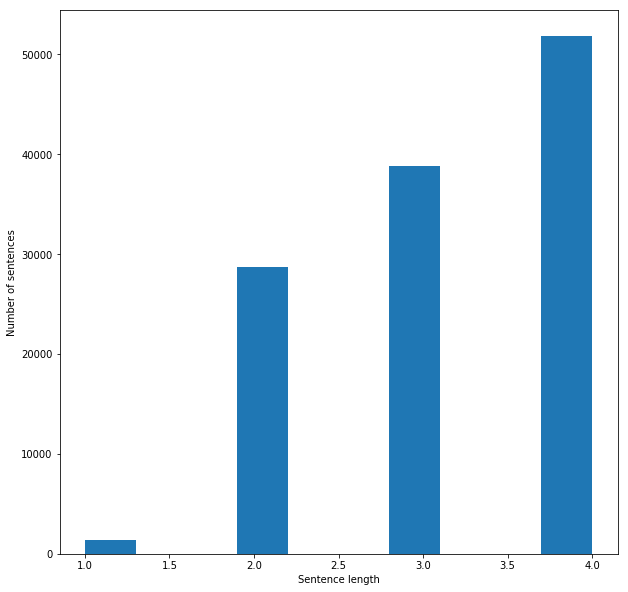

In [102]:
fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths_3)
plt.show()

In [103]:
list_corpus_cause = token_df["LossCauseName"].tolist()
list_labels_cause = token_df["FaultRatingName"].tolist()

X_train_cause, X_test_cause, y_train_cause, y_test_cause = train_test_split(list_corpus_cause, list_labels_cause, 
                                                                            test_size=0.2, random_state=42)

X_train_counts_cause, count_vectorizer_cause = cv(X_train_cause)
X_test_counts_cause = count_vectorizer_cause.transform(X_test_cause)

In [104]:
clf_3 = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=42)
clf_3.fit(X_train_counts_cause, y_train_cause)

y_predicted_counts_cause = clf_3.predict(X_test_counts_cause)

In [105]:
accuracy, precision, recall, f1 = get_metrics(y_test_cause, y_predicted_counts_cause)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

C:\Users\jnske\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\jnske\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


accuracy = 0.331, precision = 0.615, recall = 0.331, f1 = 0.391


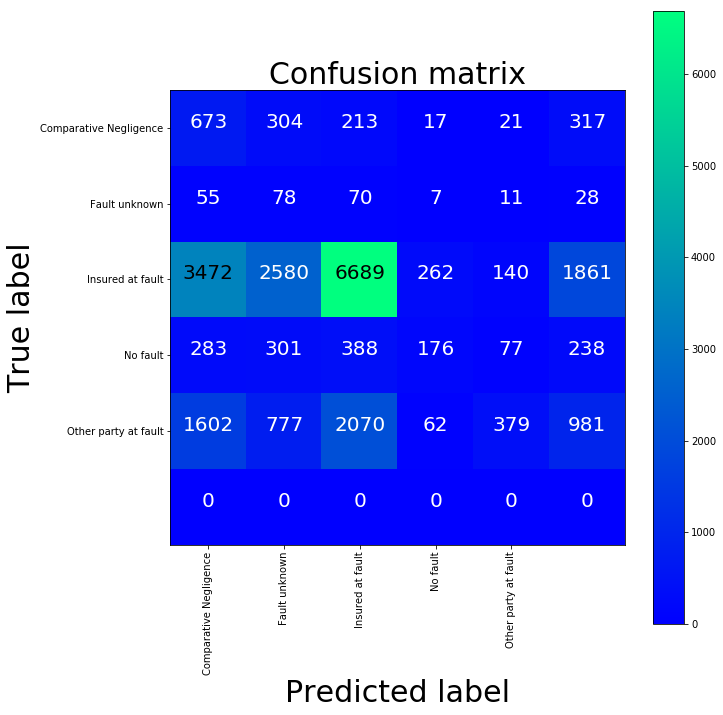

In [111]:
cm = confusion_matrix(y_test_cause, y_predicted_counts_cause)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Comparative Negligence', 'Fault unknown', 'Insured at fault', 'No fault', 
                                          'Other party at fault'], normalize=False, title='Confusion matrix')
plt.show()

In [106]:
tfidf_vectorizer_cause = TfidfVectorizer(ngram_range=(1,3))
tfidf_train_cause = tfidf_vectorizer_cause.fit_transform(X_train_cause)

tfidf_test_cause = tfidf_vectorizer_cause.transform(X_test_cause)

feature_names_cause = tfidf_vectorizer_cause.get_feature_names()
feature_names_cause

['an',
 'an intersection',
 'and',
 'and civil',
 'and civil commotion',
 'and run',
 'and vandalism',
 'animal',
 'backing',
 'bicycle',
 'bicycle motorcycle',
 'breakage',
 'bus',
 'by',
 'by or',
 'by or struck',
 'car',
 'change',
 'civil',
 'civil commotion',
 'collision',
 'collision in',
 'collision in an',
 'collision while',
 'collision while backing',
 'collision while merging',
 'collision while turning',
 'collision with',
 'collision with bicycle',
 'collision with fixed',
 'collision with motor',
 'collision with parked',
 'collision with pedestrian',
 'collision with train',
 'commotion',
 'condition',
 'cv',
 'cv rear',
 'cv rear end',
 'damage',
 'damage in',
 'damage in loading',
 'end',
 'end collision',
 'end cv',
 'end iv',
 'falling',
 'falling or',
 'falling or moving',
 'fire',
 'fixed',
 'fixed object',
 'flood',
 'glass',
 'glass breakage',
 'hail',
 'hazardous',
 'hazardous condition',
 'hit',
 'hit and',
 'hit and run',
 'in',
 'in an',
 'in an intersection'

In [107]:
# Naive Bayes 
nb_classifier = MultinomialNB(alpha=0.02)
nb_classifier.fit(tfidf_train_cause, y_train_cause)
pred_cause = nb_classifier.predict(tfidf_test_cause)

In [108]:
print(metrics.confusion_matrix(y_test_cause,pred_cause))
print('\n', 'Classification report')
print(metrics.classification_report(y_test_cause,pred_cause))
# Print the overall accuracy
print('\n', 'accuracy Score')
print(metrics.accuracy_score(y_test_cause,pred_cause))

[[   40     0  1345    89    71]
 [    0     0   181    21    47]
 [  101     0 14332   294   277]
 [   23     0  1050   241   149]
 [   29     0  3685   100  2057]]

 Classification report


C:\Users\jnske\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jnske\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jnske\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                        precision    recall  f1-score   support

Comparative Negligence       0.21      0.03      0.05      1545
         Fault unknown       0.00      0.00      0.00       249
      Insured at fault       0.70      0.96      0.81     15004
              No fault       0.32      0.16      0.22      1463
  Other party at fault       0.79      0.35      0.49      5871

             micro avg       0.69      0.69      0.69     24132
             macro avg       0.40      0.30      0.31     24132
          weighted avg       0.66      0.69      0.63     24132


 accuracy Score
0.6907840212166418


### Using a tfidf vectorization significantly increases the accuracy of our predictions, and the greatest indicator for fault is the accident description

In [112]:
list_corpus_all = list_corpus_acc+list_corpus_dmg+list_corpus_cause
list_labels_all = list_labels_acc+list_labels_dmg+list_labels_cause

X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(list_corpus_all, list_labels_all, 
                                                                    test_size=0.2, random_state=42)

X_train_counts_all, count_vectorizer_all = cv(X_train_all)
X_test_counts_all = count_vectorizer_all.transform(X_test_all)

In [113]:
clf_4 = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=42)
clf_4.fit(X_train_counts_all, y_train_all)

y_predicted_counts_all = clf_4.predict(X_test_counts_all)

In [114]:
accuracy, precision, recall, f1 = get_metrics(y_test_all, y_predicted_counts_all)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.411, precision = 0.606, recall = 0.411, f1 = 0.469


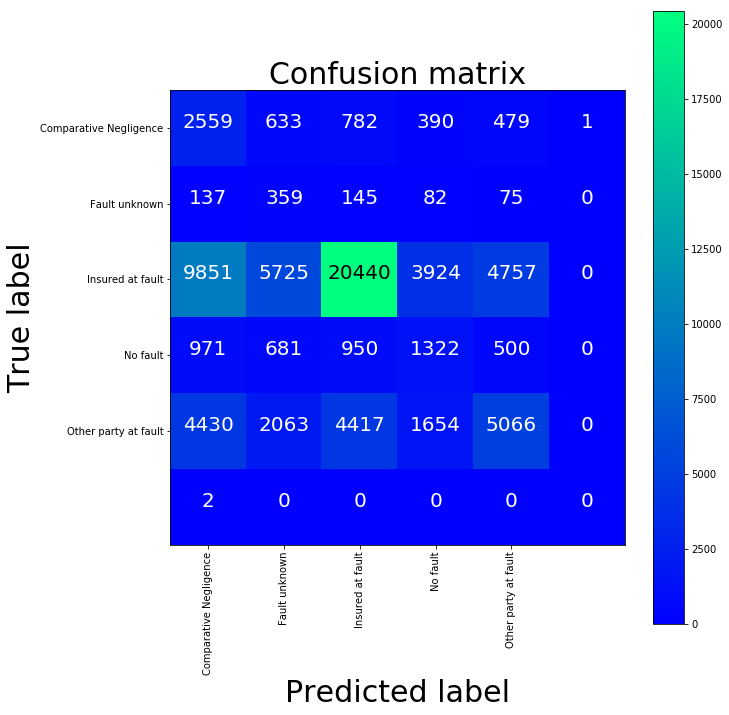

In [115]:
cm = confusion_matrix(y_test_all, y_predicted_counts_all)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Comparative Negligence', 'Fault unknown', 'Insured at fault', 'No fault', 
                                          'Other party at fault'], normalize=False, title='Confusion matrix')
plt.show()

In [116]:
tfidf_vectorizer_all = TfidfVectorizer(ngram_range=(1,3))
tfidf_train_all = tfidf_vectorizer_all.fit_transform(X_train_all)

tfidf_test_all = tfidf_vectorizer_all.transform(X_test_all)

feature_names_all = tfidf_vectorizer_all.get_feature_names()
feature_names_all

['_magills',
 '_magills towing',
 '_magills towing phone',
 'aa',
 'aa auto',
 'aa auto repair',
 'aa paint',
 'aa paint body',
 'aa quick',
 'aa quick tow',
 'aa tow',
 'aa tow service',
 'aa towing',
 'aa towing damages',
 'aa towing front',
 'aa towing marlboro',
 'aa towing phone',
 'aa towing to',
 'aa wrecker',
 'aa wrecker service',
 'aaa',
 'aaa address',
 'aaa address santa',
 'aaa at',
 'aaa at lees',
 'aaa auto',
 'aaa auto service',
 'aaa back',
 'aaa back fender',
 'aaa back left',
 'aaa back to',
 'aaa beau',
 'aaa beau townsmen',
 'aaa bryants',
 'aaa bryants towing',
 'aaa bumper',
 'aaa bumper is',
 'aaa call',
 'aaa call was',
 'aaa classic',
 'aaa classic ford',
 'aaa damages',
 'aaa damages unknown',
 'aaa dan',
 'aaa dan phone',
 'aaa entire',
 'aaa entire right',
 'aaa frencing',
 'aaa front',
 'aaa front and',
 'aaa front bumper',
 'aaa front center',
 'aaa front end',
 'aaa front left',
 'aaa front right',
 'aaa gm',
 'aaa gm towing',
 'aaa he',
 'aaa he states'

In [117]:
# Naive Bayes 
nb_classifier = MultinomialNB(alpha=0.02)
nb_classifier.fit(tfidf_train_all, y_train_all)
pred_all = nb_classifier.predict(tfidf_test_all)

In [118]:
print(metrics.confusion_matrix(y_test_all,pred_all))
print('\n', 'Classification report')
print(metrics.classification_report(y_test_all,pred_all))
# Print the overall accuracy
print('\n', 'accuracy Score')
print(metrics.accuracy_score(y_test_all,pred_all))

[[ 1490     0  2829    51   474     0]
 [   12   186   436    25   139     0]
 [  560    30 41928   333  1846     0]
 [   71     3  2739  1036   575     0]
 [  178     8  7177   194 10073     0]
 [    0     0     2     0     0     0]]

 Classification report


C:\Users\jnske\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jnske\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jnske\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                        precision    recall  f1-score   support

Comparative Negligence       0.64      0.31      0.42      4844
         Fault unknown       0.82      0.23      0.36       798
      Insured at fault       0.76      0.94      0.84     44697
              No fault       0.63      0.23      0.34      4424
  Other party at fault       0.77      0.57      0.66     17630
                   nan       0.00      0.00      0.00         2

             micro avg       0.76      0.76      0.76     72395
             macro avg       0.60      0.38      0.44     72395
          weighted avg       0.75      0.76      0.73     72395


 accuracy Score
0.7557566130257615


In [119]:
general_df.AccidentDescription=general_df.AccidentDescription.str.replace('½ ', "")

general_df.AccidentDescription=general_df.AccidentDescription.str.replace('*', "")

general_df['AccidentDescription'].str.lower().str.split().head()

stop = stopwords.words('english')
general_df['AccidentDescription'] = general_df['AccidentDescription'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
general_df.head()

general_df['AccidentDescription'] = general_df['AccidentDescription'].str.replace('[^\w\s]','')


def custom_tokenize(text):
    if not text:
        print('Not text')
        text = ''
    return word_tokenize(text)
general_df['AccidentDescription'] = general_df.AccidentDescription.apply(custom_tokenize)


from collections import defaultdict
for source in general_df:
    word_freq = defaultdict(int)
    for text in general_df.AccidentDescription:
        for word in text:
            word_freq[word] += 1 

df_dict=pd.DataFrame.from_dict(word_freq, orient='index').sort_values(0, ascending=False).reset_index().rename(columns={'index': 'AccidentDescription',0: 'Frequency'})


df_dict.head(1)

,AccidentDescription,Frequency
0,iv,172092


In [122]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
myData=df_dict.head(300)

myData

text=""
for index, row in myData.iterrows():
    str1=""
    str1= (row['AccidentDescription']+" ")*row['Frequency']
    text=text+str1

text[:100]


wordcloud = WordCloud(max_font_size=100, max_words=100, background_color="white", collocations = False).generate(text)
plt.figure(figsize=(40,40))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

ModuleNotFoundError: No module named 'wordcloud'